# Read Dataset

In [1]:
#ACCESS DATASET FROM GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from __future__ import print_function
from mpl_toolkits.mplot3d import Axes3D

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag, word_tokenize, RegexpParser

In [19]:
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train =pd.read_csv("drive/My Drive/Data/PL/train.csv")
df_train.head()

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [4]:
df_test =pd.read_csv("drive/My Drive/Data/PL/test.csv")
df_test.head()

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"During morning, a woman was walking by and thi...",1,1,0
1,A man tried to brush his penis off of a woman'...,0,0,1
2,This happened to a fellow passenger of mine tr...,0,1,0
3,ogling,0,1,0
4,When I was returning my home after finishing m...,0,0,1


In [5]:
def append_len(data):#function to length of description field
  s = []
  for i in data['Description']:
      s.append(len(i))
  return s

In [6]:
print('\n Length of \n train dataset is {}, \n test dataset is {}'.format(len(df_train),len(df_test)))


 Length of 
 train dataset is 7201, 
 test dataset is 1701


# Data Pre Processing + EDA

## Data Cleaning


We follow the following Sequence to clean the data
1. Decontract Words
2. Remove Special Symbols
3. Remove Stopwords
4. Remove HTML tags
5. Remove Punctuations
6. Lemmatize the sentence using WordNetLemmatizer

In [7]:
def clean_text(phrase):
    '''
    The function performs the following steps in order
    1. Decontract Words
    2. Remove Special Symbols
    3. Remove Stopwords
    4. Remove HTML tags
    5. Remove Punctuations

    '''
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    # remove special symbols
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)

    # remove stopwords
    phrase = ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords.words('english'))

    #clean html
    cleanr = re.compile('<.*?>')
    phrase = re.sub(cleanr, ' ', str(phrase))

    #remove punctuations and special character
    phrase = re.sub(r'[?|!|\'|"|#]',r'',phrase)
    phrase = re.sub(r'[.|,|)|(|\|/]',r' ',phrase)
    phrase = phrase.strip()
    phrase = phrase.replace("\n"," ")

    return phrase

def lemmatize(sentence):
  '''
  Lemmatize the sentence using WordNetLemmatizer
  '''
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = " ".join([lemmatizer.lemmatize(word) for word in sentence.split(" ")])
  return lemmatized_sentence 

def pre_process_text(sentence):
  '''
  calls clean_text and lemmatize methods and also corrects simple spellings using TextBlob
  '''
  sentence = clean_text(sentence)
  sentence = lemmatize(sentence)

  # Spelling corrections
  sentence = TextBlob(sentence).correct()
  return str(sentence)

In [15]:
# Pre process the data using pre_process_text function we defined earlier
# df_train["Description"] = df_train["Description"].apply(pre_process_text)
# df_train_desc = df_train["Description"]

# Load Cleaned Dataset saved earlier
df_train = pd.read_csv("train_data.csv")
df_train = df_train.drop(columns=["description"])
df_train = df_train.dropna()

In [9]:
df_train.head()

,Description,Commenting,Staring,Groping
0,bus approaching place highly safe,1,0,1
1,man commenting,1,0,0
2,share auto,0,0,1
3,coming club night friend guy came stopped u as...,1,0,0
4,one friend molested crowd happened 9 bridge th...,0,0,1


## Get data for each label

In order to analyze data with respect to each class label, here we seggregate the data according to the classes, so that we can analyze the data better.

- Also for each Description in dataset, we generate a count_dictionary which is dictionary which contains all the words and word_count for that particular data point. This will help us further when we want to calculate features like word_length and frequent_words
- We want to look at most frequent words as well as bigrams. So we also extract the bigrams from each text using nltk and store them

In [10]:
def filter_into_categories(row):
  '''
  Save all the descriptions for a particular Category
  into comment_data, stare_data, grope_data  arrays
  Also for each datapoint store its word_counts to be used later
  '''

  text = row["Description"]
  uni_words_dict = dict(Counter(text.split()))

  # find bi_grams
  bigrams = list(nltk.bigrams(nltk.word_tokenize(text)))
  bigrams = [" ".join(words) for words in bigrams] 
  bi_words_dict = dict(Counter(bigrams))


  if row["Groping"] == 1:
    uni_grope_data.append(uni_words_dict)
    bi_grope_data.append(bi_words_dict)
  if row["Staring"] == 1:
    uni_stare_data.append(uni_words_dict)
    bi_stare_data.append(bi_words_dict)
  if row["Commenting"] == 1:
    uni_comment_data.append(uni_words_dict)
    bi_comment_data.append(bi_words_dict)

  return uni_words_dict


In [20]:
from collections import Counter
uni_comment_data, uni_stare_data, uni_grope_data = [],[],[]
bi_comment_data, bi_stare_data, bi_grope_data = [],[],[]

df_train["word_dict"] = df_train.apply(filter_into_categories,axis=1)
df_train.head(5)

,Description,Commenting,Staring,Groping,word_dict
0,bus approaching place highly safe,1,0,1,"{'bus': 1, 'approaching': 1, 'place': 1, 'high..."
1,man commenting,1,0,0,"{'man': 1, 'commenting': 1}"
2,share auto,0,0,1,"{'share': 1, 'auto': 1}"
3,coming club night friend guy came stopped u as...,1,0,0,"{'coming': 1, 'club': 1, 'night': 1, 'friend':..."
4,one friend molested crowd happened 9 bridge th...,0,0,1,"{'one': 1, 'friend': 1, 'molested': 1, 'crowd'..."


# EDA and Visualization

## Plot frequent 15 words and also the Wordcloud for each class

The function takes data points and plots a wordcloud. This can help us get a brief idea about how frequently some words may appear.

In [21]:
# data : [(word,freq)]
def plot_wordcloud(data, label): 
  '''
  Plot the wordcloud for given data corpus
  ''' 
  stopwords = set(STOPWORDS)
  total_words = " "
  for word_dict in data:
    total_words += " ".join(word_dict.keys())

  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,min_font_size = 10).generate(total_words)
    
  # plot the WordCloud image                       
  plt.figure(figsize = (5, 5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title("Wordcloud for "+label)
    
  plt.show()


Th function plot_frequent() calculates the 15 most frequent words in the given data. Here we make use of word_dict we have created earlier for each data_point to find the frequency of words

In [22]:
# data : [(word,freq)]
# label : heading
def plot_frequent(data,label):
  '''
  Find the top 15 most frequent words in each text corpus and plot their count
  Also return this list
  '''
  word_freq = {}
  for words in data:
    for key,val in words.items():
      word_freq[key] = word_freq.get(key,1)+val

  sorted_word_freq = sorted(word_freq.items(),key = lambda x: x[1], reverse=True)
  x = list(map(lambda x: x[0],sorted_word_freq[:15]))
  y = list(map(lambda x: x[1],sorted_word_freq[:15]))

  plt.figure(figsize=(25, 6))
  plt.subplot(1, 2, 1)
  g = sns.barplot(y,x, palette="winter",  orient = 'h')
  plt.title(label)
  g.set_yticklabels(x,rotation=0)

  for index, value in enumerate(y):
    plt.text(value,index,str(value))
    
  plt.show()

  return sorted_word_freq[:15]


### Considering only Unigrams

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


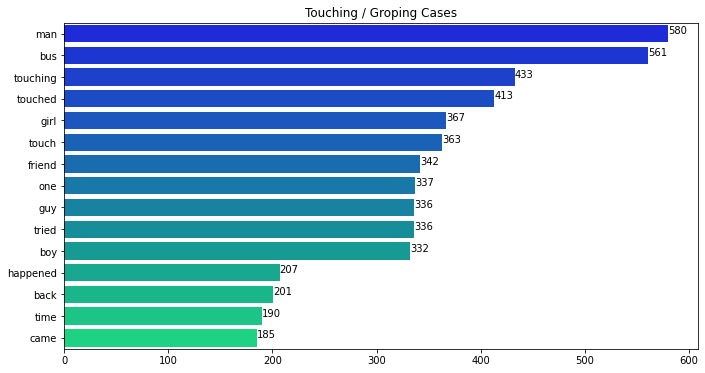

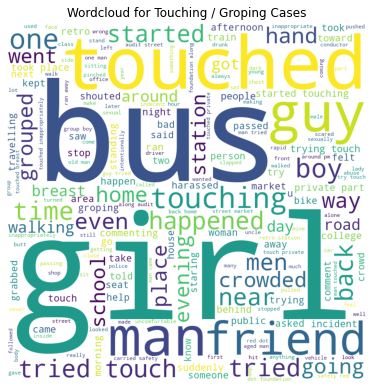

In [23]:
grope_freq = plot_frequent(uni_grope_data,"Touching / Groping Cases")
# print()
plot_wordcloud(uni_grope_data, "Touching / Groping Cases")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


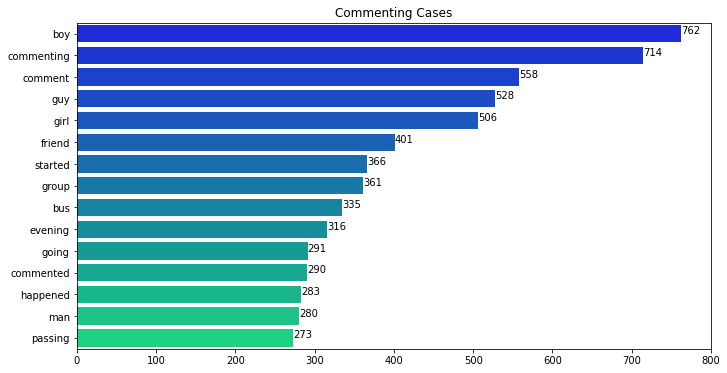

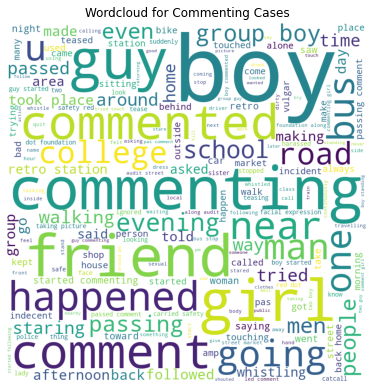

In [24]:
comment_freq = plot_frequent(uni_comment_data,"Commenting Cases")
print()
plot_wordcloud(uni_comment_data, "Commenting Cases")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


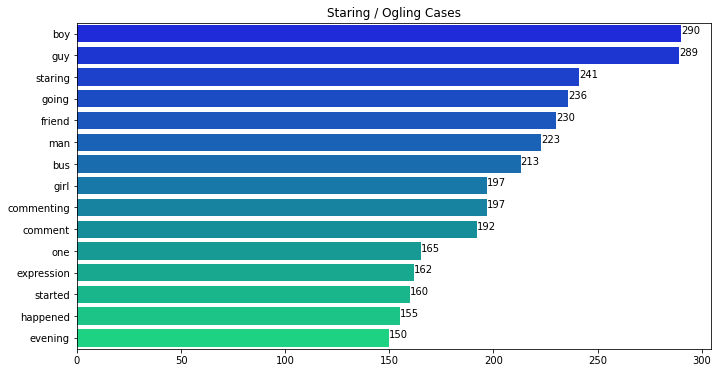

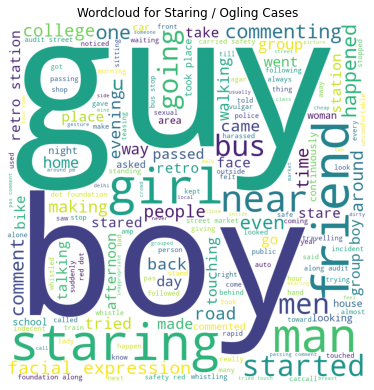

In [25]:
stare_freq = plot_frequent(uni_stare_data,"Staring / Ogling Cases")
print()
plot_wordcloud(uni_stare_data, "Staring / Ogling Cases")


**Groping cases**
- Here we can see that the words man, bus, touching and touched are the most frequent 4 words.
- The words like 'bus' makes perfect sense as most groping cases may happen in crowded places like buses.
Wordcloud too emphasizes the same

**Commenting**
- The words boy, commenting and comment are the 3-most frequent words.
- Words boy and commenting occur 762,714 time which is almost 30-40% more than the next frequent word i.e comment,guy etc

**Staring**
= Here the top-frequent words are boy, guy, staring, going.

**Some Important Observations**
- We can see that some words appear commonly in all 3 classes. Such words are boy, guy, man, bus. We need to research more into this.
- Also, we see that words which are similar to the class_name are also very frequent. Ex. comment, commenting in case of Commenting cases, touching and touched in case of Groping cases. This can help us to identify classes better


### Considering only Bigrams

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


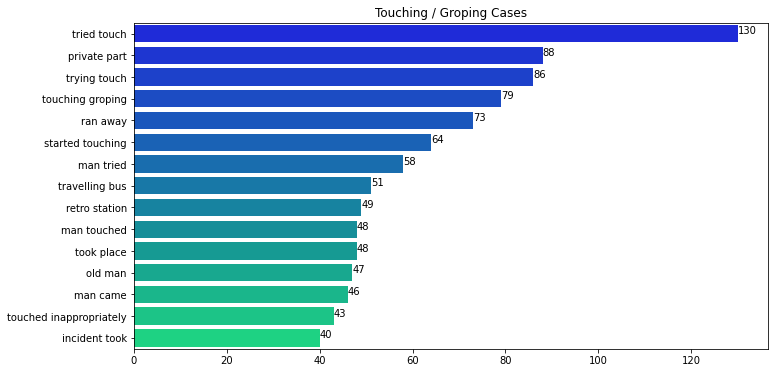

In [26]:
bi_grope_freq = plot_frequent(bi_grope_data,"Touching / Groping Cases")
print()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


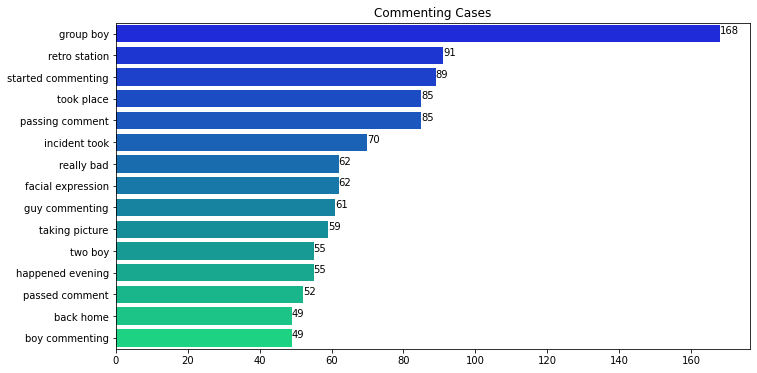

In [27]:
bi_comment_freq = plot_frequent(bi_comment_data,"Commenting Cases")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


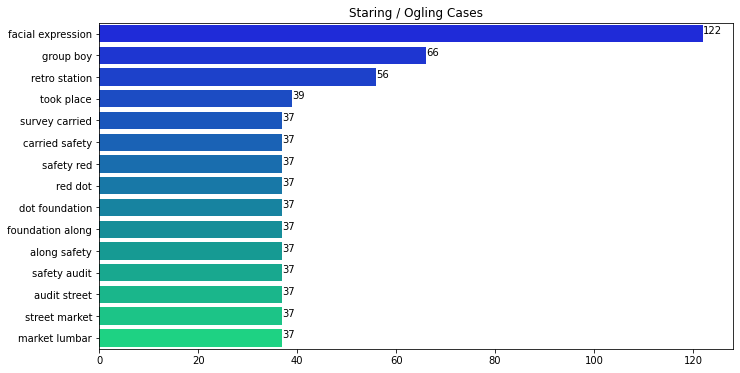

In [28]:
bi_stare_freq = plot_frequent(bi_stare_data,"Staring / Ogling Cases")

**Observations**

- As we observed in case of Unigrams, words which are similar to the actual class labels appear more frequently. 
- In case of Groping cases, "tried touching"," trying touch" were significantly more frequent.
- In case of Commenting cases we saw "started commenting","passed comment"

- For Commenting cases, we see some interesting words.
"group boy" and "retro station" indicate presence of a group of boys in public places like stations lead to commenting cases.
- We see an overlap between the common words in Staring and Commenting cases. Thus it would hard to use the words like "facial expression","group boy","Station" to differentiate between the classes.


### Check if any words are in Top Frequent words in all classes

As in the previous steps, we saw that some words we commonly frequent in all the classes. We will try to look deeper in this issue n check

In [29]:
# we only need words n not their count
comment_freq = [x[0] for x in comment_freq]
grope_freq = [x[0] for x in grope_freq]
stare_freq = [x[0] for x in stare_freq]

# grope_freq , comment_freq , stare_freq
def common_label_count():
  '''
      Calculate which words appear frequently in more than one class
  '''
  word_label_count = {1:[], 2:[] ,3:[]}
  words = set(comment_freq + grope_freq + stare_freq) #all top frequent words in 3 classes
  for word in words:
    count = 0
    if word in comment_freq:
      count += 1
    if word in grope_freq:
      count += 1
    if word in stare_freq:
      count += 1
    word_label_count[count].append(word)
  
  return word_label_count

In [30]:
count_dict = common_label_count()
print("Frequent words common in 2 clases :",count_dict[2])
print("Frequent words common in all clases :",count_dict[3])

Frequent words common in 2 clases : ['going', 'comment', 'commenting', 'one', 'started', 'evening']
Frequent words common in all clases : ['boy', 'man', 'friend', 'girl', 'happened', 'guy', 'bus']


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


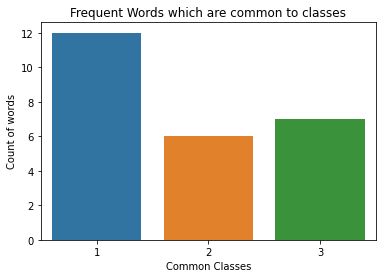

In [31]:
sns.barplot(list(count_dict.keys()), list([len(val) for val in count_dict.values()]) )
plt.title("Frequent Words which are common to classes")
plt.xlabel("Common Classes")
plt.ylabel("Count of words")
plt.show()

 Observations
- We see that 6 words (comment', 'started', 'one', 'commenting', 'evening', 'going) appear frequently in 2 classes 
- Similarly 7 words ('man', 'bus', 'happened', 'friend', 'girl', 'guy', 'boy') appear in top-10 most frequent words in all 3 classes.
- Hence, we can conclude that these words cannot help our decision process much as they appear in all 3 classes

## AVERAGE SENTENCE LENGTH

In [ ]:
def calculate_len(data):#function to calculate average sentence length of description field
  m = 0
  for i in data['Description']:
      m += len(i)
  return int(m/len(data))  

In [ ]:
print('\n Average Length of Description \n train dataset is {}, \n test dataset is {}'.format(calculate_len(df_train),calculate_len(df_test)))


 Average Length of Description 
 train dataset is 124, 
 test dataset is 119


## COMMENTING 

Text(0.5, 1.0, 'Test Dataset')

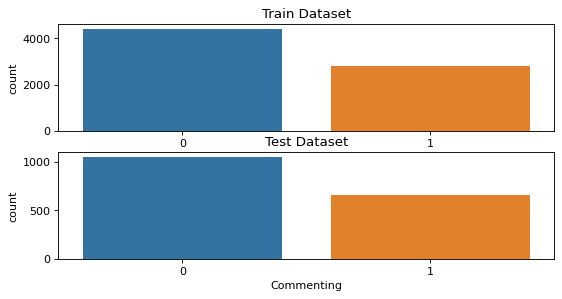

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.subplot(311)
ax1 = sns.countplot(x="Commenting", data=df_train)
ax1.set_title('Train Dataset')
plt.subplot(312)
ax2 = sns.countplot(x="Commenting", data=df_test)
ax2.set_title('Test Dataset')

Text(0.5, 1.0, 'Test Dataset')

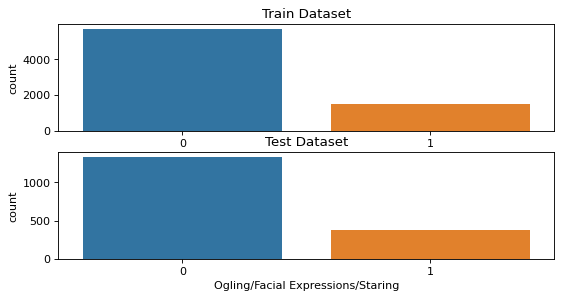

In [ ]:

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.subplot(311)
ax1 = sns.countplot(x="Ogling/Facial Expressions/Staring", data=df_train)
ax1.set_title('Train Dataset')
plt.subplot(312)
ax2 = sns.countplot(x="Ogling/Facial Expressions/Staring", data=df_test)
ax2.set_title('Test Dataset')

Text(0.5, 1.0, 'Test Dataset')

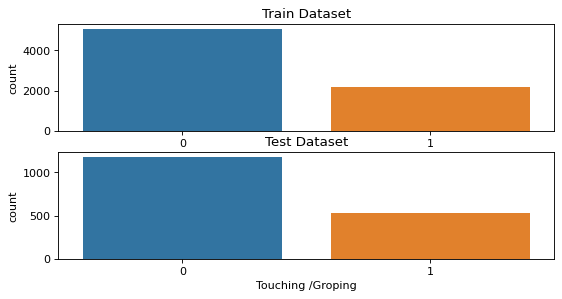

In [ ]:

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.subplot(311)
ax1 = sns.countplot(x="Touching /Groping", data=df_train)
ax1.set_title('Train Dataset')
plt.subplot(312)
ax2 = sns.countplot(x="Touching /Groping", data=df_test)
ax2.set_title('Test Dataset')

In [ ]:
def chk_duplicate(data):
  df = data[data.duplicated()]
  return df,len(df)
train_duplicate,count = chk_duplicate(df_train)
print('Number of duplicate rows',count)
print(train_duplicate)

Number of duplicate rows 428
                                            Description  Commenting  \
388   This survey is carried out by safecity (Red do...           1   
447                                  it was really bad.           1   
452                                  it was really bad.           1   
460                                          misbehaved           0   
537                                  it was really bad.           1   
...                                                 ...         ...   
7109                            Harassed in the evening           0   
7114                                         misbehaved           1   
7119                                         misbehaved           1   
7150                                happened in morning           1   
7175                                         misbehaved           1   

      Ogling/Facial Expressions/Staring  Touching /Groping  
388                                   1                  

In [ ]:
test_duplicate,count = chk_duplicate(df_test)
print('Number of duplicate rows',count)
print(test_duplicate)

Number of duplicate rows 61
                                            Description  Commenting  \
99          I was standing when a neighbour spanked me.           0   
150                                          harassment           1   
165                                   Touching, groping           0   
286                                  it was really bad.           1   
295                                          harassment           1   
...                                                 ...         ...   
1597                                         misbehaved           1   
1630                                         harassment           1   
1636  This survey is carried out by safecity (Red Do...           1   
1637                                 it was really bad.           1   
1663                                    chain snatching           0   

      Ogling/Facial Expressions/Staring  Touching /Groping  
99                                    0                  1

We see similar instances of duplication with different categories assigned in the test and validation datasets as well.

Some descriptions also are not very informative like:-

- it was really bad.
- This survey is carried out by safecity (Red Do...
- misbehaved
- harassment

## Conclusion

As part of the step of EDA in this case study we looked into description and category fields of the single and multilabel datasets and our findings are as below:-

1) Data is highly imbalanced in most of the cases

2) Duplicate data is present for description with difference in categories for different occurences in the single label datasets

# PreProcessing of description feature

Dropping duplicate description rows

In [ ]:
df_train.drop_duplicates(subset="Description",keep= False, inplace = True)

In [ ]:
## Removing punctuation symbols and special characters
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(data):
    stop = stopwords.words('english')
    res = []
    data['Description'] = data['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    for x in data['Description']:
        x = str(x)
        for punct in puncts:
            if punct in x:
                    x = x.replace(punct,' ')
        res.append(x)
    return res